#Task 0 : Downloading the MNIST dataset

In [12]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define transformations
def get_transform():
    # Compose a series of image transformations:
    return transforms.Compose([
        transforms.RandomRotation(15),  # Randomly rotate the image up to 15 degrees
        transforms.RandomCrop(28, padding=2),  # Randomly crop the image to size 28x28 with padding of 2 pixels
        transforms.ToTensor(),  # Convert the image to PyTorch tensor format
        transforms.Normalize((0.5,), (0.5,))  # Normalize the image tensor with mean 0.5 and standard deviation 0.5
    ])

# Function to get training and testing datasets
def get_datasets(transform):
    # Load the MNIST dataset, applying the specified transformations
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Function to split dataset into training and validation sets
def split_dataset(dataset):
    # Define the size of training and validation sets
    train_size = int(0.8 * len(dataset))  # 80% of the dataset for training
    val_size = len(dataset) - train_size  # Remaining for validation
    # Randomly split the dataset into training and validation sets
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

# Get the transformation
transform = get_transform()
# Get the training and testing datasets with the defined transformation
train_dataset, test_dataset = get_datasets(transform)
# Split the training dataset into training and validation sets
train_dataset, val_dataset = split_dataset(train_dataset)


#Task 1 : Plotting images and creating DataLoaders

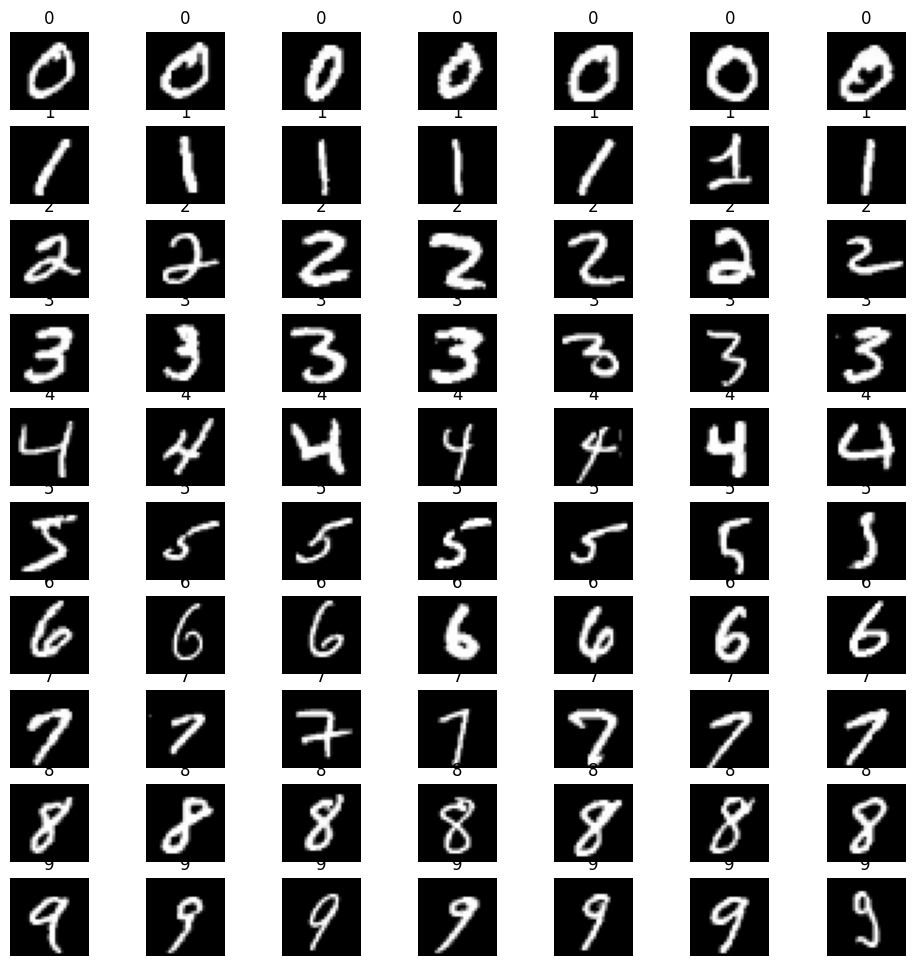

In [13]:
def plot_images(dataset, num_images=5):
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')  # Define class labels
    fig, axs = plt.subplots(10, num_images, figsize=(12, 12))  # Create subplots for each class
    for i in range(10):  # Iterate over each class
        idx = dataset.dataset.targets == i  # Filter indices for images of class i using dataset's targets attribute
        images = dataset.dataset.data[idx][:num_images]  # Get images of class i from the dataset's data attribute
        for j in range(num_images):  # Iterate over each image
            axs[i, j].imshow(images[j], cmap='gray')  # Display the image
            axs[i, j].set_title(classes[i])  # Set the title as the class label
            axs[i, j].axis('off')  # Turn off axis labels
    plt.show()  # Display the plot


def get_data_loaders(train_dataset, val_dataset):
    # Create data loaders for training, testing, and validation datasets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
    return train_loader, test_loader, val_loader  # Return the data loaders

# Plot sample images from the training dataset
plot_images(train_dataset, num_images=7)

# Get data loaders for training, testing, and validation datasets
train_loader, test_loader, val_loader = get_data_loaders(train_dataset, val_dataset)


#Task 2 : Implementing a 3-Layer Perceptron using PyTorch

In [14]:
def get_model():
    # Define a simple feedforward neural network model using nn.Sequential
    model = nn.Sequential(
        nn.Linear(28*28, 128),  # Input layer: 28*28 input features, outputting to 128 neurons
        nn.ReLU(),  # ReLU activation function
        nn.Linear(128, 64),  # Hidden layer: 128 input neurons, outputting to 64 neurons
        nn.ReLU(),  # ReLU activation function
        nn.Linear(64, 10)  # Output layer: 64 input neurons, outputting to 10 neurons (for 10 classes)
    )
    return model

def train_neural_network(model, train_loader, val_loader, optimizer, loss_function, num_epochs=5, device='cpu'):
    model.to(device)  # Move the model to the specified device (CPU or GPU)
    train_loss_values = []  # Store training loss values for each epoch
    val_loss_values = []  # Store validation loss values for each epoch
    train_accuracy_values = []  # Store training accuracy values for each epoch
    val_accuracy_values = []  # Store validation accuracy values for each epoch
    best_validation_loss = float('inf')  # Initialize best validation loss to infinity
    best_model_state = None  # Initialize the best model state

    for epoch in range(num_epochs):  # Iterate over the specified number of epochs
        model.train()  # Set the model to training mode
        total_training_loss = 0.0  # Initialize total training loss
        correct_training_predictions = 0  # Initialize the count of correct training predictions
        total_training_samples = 0  # Initialize the total count of training samples

        for inputs, labels in train_loader:  # Iterate over training data batches
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the specified device
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs.view(inputs.size(0), -1))  # Forward pass: flatten input before passing to model
            loss = loss_function(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimizer step
            total_training_loss += loss.item()  # Accumulate training loss
            _, predicted = torch.max(outputs, 1)  # Get the predicted classes
            total_training_samples += labels.size(0)  # Accumulate total training samples
            correct_training_predictions += (predicted == labels).sum().item()  # Count correct predictions

        training_accuracy = correct_training_predictions / total_training_samples  # Compute training accuracy
        train_loss_values.append(total_training_loss / len(train_loader))  # Compute and store average training loss
        train_accuracy_values.append(training_accuracy)  # Store training accuracy

        model.eval()  # Set the model to evaluation mode
        total_validation_loss = 0.0  # Initialize total validation loss
        correct_validation_predictions = 0  # Initialize the count of correct validation predictions
        total_validation_samples = 0  # Initialize the total count of validation samples

        with torch.no_grad():  # Disable gradient calculation for validation
            for inputs, labels in val_loader:  # Iterate over validation data batches
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the specified device
                outputs = model(inputs.view(inputs.size(0), -1))  # Forward pass: flatten input before passing to model
                loss = loss_function(outputs, labels)  # Compute the loss
                total_validation_loss += loss.item()  # Accumulate validation loss
                _, predicted = torch.max(outputs, 1)  # Get the predicted classes
                total_validation_samples += labels.size(0)  # Accumulate total validation samples
                correct_validation_predictions += (predicted == labels).sum().item()  # Count correct predictions

        validation_accuracy = correct_validation_predictions / total_validation_samples  # Compute validation accuracy
        val_loss_values.append(total_validation_loss / len(val_loader))  # Compute and store average validation loss
        val_accuracy_values.append(validation_accuracy)  # Store validation accuracy

        if total_validation_loss < best_validation_loss:  # Check if current validation loss is the best so far
            best_validation_loss = total_validation_loss  # Update best validation loss
            best_model_state = model.state_dict()  # Save the best model state

        # Print epoch-wise training and validation metrics
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Training Loss: {train_loss_values[-1]:.4f}, Training Accuracy: {training_accuracy:.4f}, "
              f"Validation Loss: {val_loss_values[-1]:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    return best_model_state, train_loss_values, val_loss_values, train_accuracy_values, val_accuracy_values

# Get the neural network model
model = get_model()
# Determine the device (CPU or GPU) to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the optimizer (Adam) and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the loss function (CrossEntropyLoss)
loss_function = nn.CrossEntropyLoss()
# Train the neural network
best_model_state, train_loss_values, val_loss_values, train_accuracy_values, val_accuracy_values = train_neural_network(model, train_loader, val_loader, optimizer, loss_function, num_epochs=5, device=device)


Epoch 1/5, Training Loss: 0.9585, Training Accuracy: 0.6922, Validation Loss: 0.5936, Validation Accuracy: 0.8107
Epoch 2/5, Training Loss: 0.4734, Training Accuracy: 0.8533, Validation Loss: 0.3542, Validation Accuracy: 0.8886
Epoch 3/5, Training Loss: 0.3505, Training Accuracy: 0.8917, Validation Loss: 0.3336, Validation Accuracy: 0.8944
Epoch 4/5, Training Loss: 0.2940, Training Accuracy: 0.9103, Validation Loss: 0.2786, Validation Accuracy: 0.9123
Epoch 5/5, Training Loss: 0.2693, Training Accuracy: 0.9181, Validation Loss: 0.2711, Validation Accuracy: 0.9192


# Task 4 : Visualizing Correct/Incorrect predictions

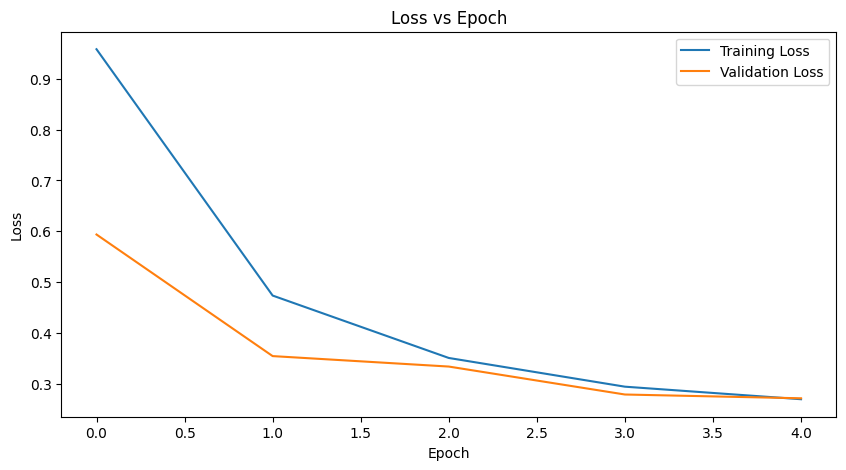

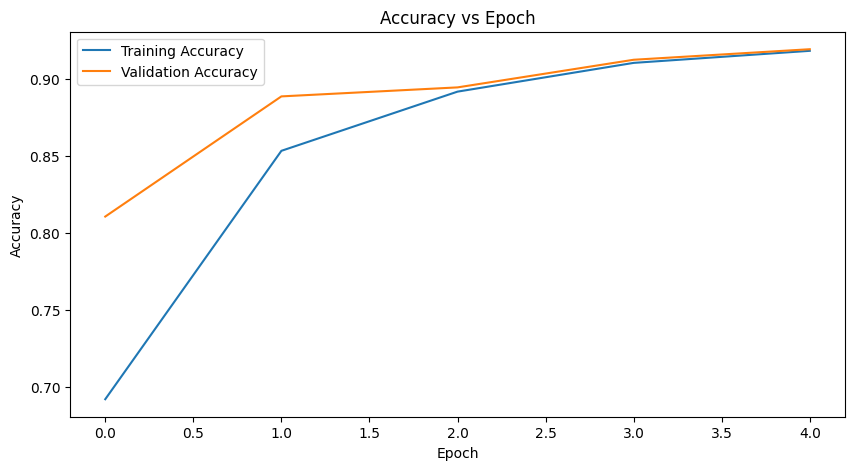

In [15]:
# Visualize training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

# Visualize training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()
